# Textual Analysis
# Fake News Detection

# Loading original Dataset

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Shaurya\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\1


# Loading Libraries

In [28]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import joblib
import logging



# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
# nltk
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# transformers
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, AutoModel,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertTokenizerFast, TFDistilBertForSequenceClassification 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shaurya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shaurya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Setting up the environment

In [12]:
RANDOM_SEED = 126233
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TFIDF_MAX_FEATURES = 5000
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 1

# Fake News + True News table concatenation + Labeling

In [13]:
Fake_data = pd.read_csv(os.path.join(path, "Fake.csv"))
True_data = pd.read_csv(os.path.join(path, "True.csv"))
Fake_data['label'] = 0
True_data['label'] = 1
display(True_data.head()) 
display(Fake_data.head())

dataset = pd.concat([True_data, Fake_data])
display(dataset.head())


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# EDA + Preprocessing 

In [14]:
dataset.isnull().sum() 
stop_words = set(stopwords.words('english'))

In [15]:
dataset.drop(columns=['title', 'subject', 'date'], inplace=True)

In [16]:
display(dataset.head())

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [17]:
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    # simple cleaning
    text = text.lower()
    text = re.sub(r'https?://\S+', ' ', text)  # remove urls
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def editText(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1 and not t.isdigit()]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


# Splitting the dataset into training and testing

In [18]:
X_train, X_test, y_train, y_test, raw_train, raw_test = train_test_split(
    dataset['text'], dataset['label'], dataset['text'], test_size=0.2, random_state=RANDOM_SEED, stratify=dataset['label']
)
# Preprocess each
X_train_clean = [editText(text) for text in X_train]
X_test_clean  = [editText(text) for text in X_test]

# TF-IDF on training only
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf  = tfidf.transform(X_test_clean)

# Setting up Classical Models

In [19]:
classic_models = {
    'LR': LogisticRegression(max_iter=2000),
    'NB': MultinomialNB(),
    'SVM': LinearSVC()
}

In [20]:
fitted = {}
results = {}

for name, model in classic_models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_tfidf, y_train)
    fitted[name] = model
    probs = model.predict_proba(X_test_tfidf)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_tfidf)
    preds = model.predict(X_test_tfidf)
    res = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds),
        'roc_auc': roc_auc_score(y_test, probs)
    }
    results[name] = res
    print(name, res)




Training LR ...
LR {'accuracy': 0.9881959910913141, 'precision': 0.9855880985588099, 'recall': 0.9897292250233427, 'f1': 0.9876543209876543, 'roc_auc': 0.9986259836132068}

Training NB ...
NB {'accuracy': 0.9301781737193764, 'precision': 0.9342199002612206, 'recall': 0.9183006535947712, 'f1': 0.9261918775750442, 'roc_auc': 0.978219190856354}

Training SVM ...
SVM {'accuracy': 0.99543429844098, 'precision': 0.9955617846297594, 'recall': 0.9948646125116714, 'f1': 0.9952130764740221, 'roc_auc': 0.9995949827972075}


# Visualizing the results

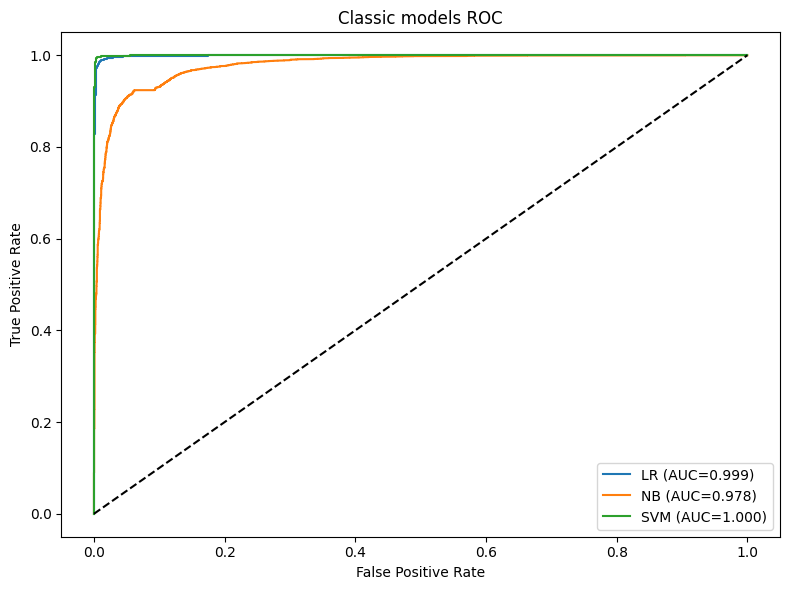

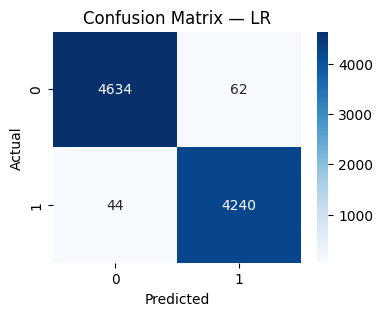

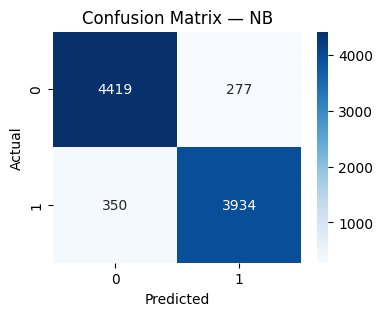

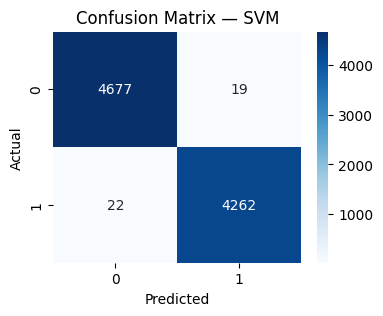

In [21]:
# ---------- Evaluation helper & ROC plotting ----------
def plot_roc(models_dict, X_test_feat, y_test, title="ROC Curves"):
    plt.figure(figsize=(8,6))
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test_feat)[:,1]
        else:
            probs = model.decision_function(X_test_feat)
            probs = (probs - probs.min()) / (probs.max() - probs.min())
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(fitted, X_test_tfidf, y_test, title="Classic models ROC")

# ---------- Confusion matrices ----------
def plot_conf_matrix(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

for name, model in fitted.items():
    preds = model.predict(X_test_tfidf)
    plot_conf_matrix(name, y_test, preds)

# Feature Importance from Classical Models

In [22]:
import numpy as np

feature_names = tfidf.get_feature_names_out()

# Logistic Regression example:
coef = classic_models['LR'].coef_[0]

# Top 20 real-news indicators
top_real_idx = np.argsort(coef)[-20:]
top_real_words = [(feature_names[i], coef[i]) for i in top_real_idx]

# Top 20 fake-news indicators
top_fake_idx = np.argsort(coef)[:20]
top_fake_words = [(feature_names[i], coef[i]) for i in top_fake_idx]

print("Top REAL words:")
for w, c in reversed(top_real_words):
    print(w, "→", c)

print("\nTop FAKE words:")
for w, c in top_fake_words:
    print(w, "→", c)

Top REAL words:
reuters → 26.986565560720905
said → 16.35115833219051
washington → 6.5752584461591
tuesday → 5.102479612034557
wednesday → 5.0778935913318906
thursday → 4.765421421281248
friday → 4.437138010805913
nov → 4.201056650786469
monday → 4.065283377544496
presidential → 3.747692438127577
minister → 3.6354718724156565
representative → 3.378231937018812
london → 3.3694400056632627
statement → 3.322175869833534
edt → 3.302448939345526
republican → 3.0558996868840613
spokesman → 3.0281347191277264
democratic → 2.944215721869239
saying → 2.8223754015667284
comment → 2.8067097934714424

Top FAKE words:
via → -11.029440943189341
image → -6.637513866430631
read → -6.057961791264327
gop → -5.3367175786670265
mr → -5.059668542550547
featured → -4.727701166953412
hillary → -4.353772274320749
com → -4.348196737371131
even → -4.336205621104811
american → -4.017508014255125
pic → -3.9324625769756354
sen → -3.9037392495619807
america → -3.859914623894707
obama → -3.830943484140757
watch → -3

# Running K-Means for Topic Modeling


Cluster vs True Label Distribution:
label      0     1
row_0             
0      10263  2043
1         80   849
2        684  2844
3        562  8526
4       5450  2177
5       1746   694

Top words per cluster:
Cluster 0: said, police, people, obama, one, woman, year, black, state, trump
Cluster 1: korea, north, korean, nuclear, missile, china, south, said, pyongyang, test
Cluster 2: republican, tax, senate, bill, said, house, trump, would, democrat, vote
Cluster 3: said, state, reuters, government, minister, united, party, president, iran, would
Cluster 4: trump, president, donald, said, republican, campaign, white, image, would, people
Cluster 5: clinton, hillary, trump, email, sander, campaign, said, state, democratic, fbi


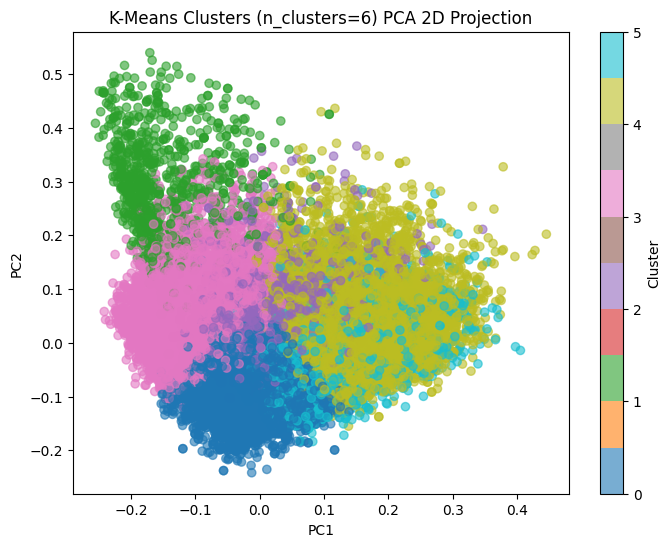

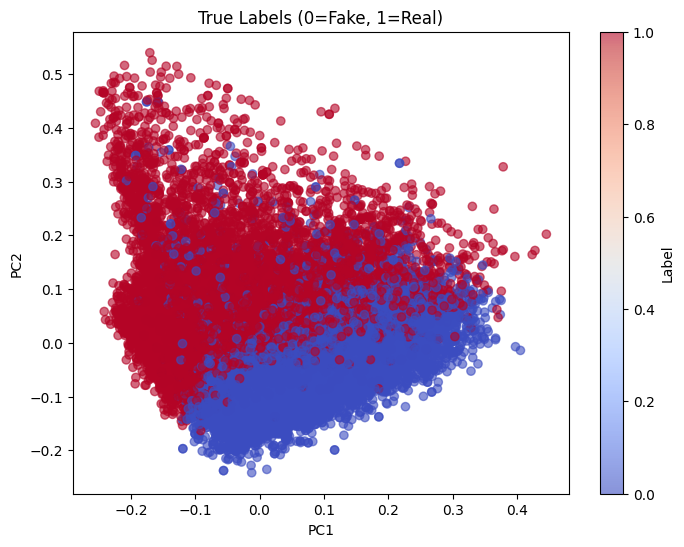

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def kmeans_topic_model(X_tfidf, tfidf_vectorizer, y=None, n_clusters=6, top_n_words=10, random_state=42):
   
    # ---------- Fit K-Means ----------
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    kmeans.fit(X_tfidf)
    
    clusters = kmeans.predict(X_tfidf)
    
    print("\nCluster vs True Label Distribution:")
    if y is not None:
        print(pd.crosstab(clusters, y))
    else:
        print(pd.Series(clusters).value_counts().sort_index())
    
    # ---------- Top words per cluster ----------
    terms = tfidf_vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    
    print("\nTop words per cluster:")
    for i in range(n_clusters):
        top_words = [terms[idx] for idx in order_centroids[i, :top_n_words]]
        print(f"Cluster {i}: {', '.join(top_words)}")
    
    # ---------- PCA visualization ----------
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_tfidf.toarray())
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)
    plt.title(f"K-Means Clusters (n_clusters={n_clusters}) PCA 2D Projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label="Cluster")
    plt.show()
    
    # Optional: visualize true labels if provided
    if y is not None:
        plt.figure(figsize=(8,6))
        plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
        plt.title("True Labels (0=Fake, 1=Real)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.colorbar(label="Label")
        plt.show()

# X_train_tfidf = your TF-IDF features
# tfidf = your fitted TfidfVectorizer
# y_train = true labels

kmeans_topic_model(X_train_tfidf, tfidf_vectorizer=tfidf, y=y_train, n_clusters=6)



# Transformer

In [30]:

# ------------------------ 4️⃣ Tokenization ------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

train_encodings = tokenizer(
    X_train_clean,
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

test_encodings = tokenizer(
    X_test_clean,
    truncation=True,
    padding=True,
    max_length=MAX_LEN
)

# ------------------------ 5️⃣ Create TensorFlow Datasets ------------------------
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ------------------------ 6️⃣ Load Model ------------------------
# Safe: force conversion from PyTorch if needed
model = TFDistilBertForSequenceClassification.from_pretrained(
    "sentence-transformers/all-MiniLM-L6-v2",
    num_labels=2,
    from_pt=True
)

# ------------------------ 7️⃣ Compile Model ------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# ------------------------ 8️⃣ Train Model ------------------------
model.fit(train_dataset, validation_data=test_dataset, epochs=1)

# ------------------------ 9️⃣ Save Model ------------------------
model.save_pretrained("./distilbert_fake_real_model")
tokenizer.save_pretrained("./distilbert_fake_real_model")

print("✅ Training complete and model saved!")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['encoder.layer.0.output.LayerNorm.weight', 'embeddings.position_ids', 'encoder.layer.4.output.dense.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.3.attention.output.de

1123/1123 [==============================] - 8476s 8s/step - loss: 0.0889 - accuracy: 0.9635 - val_loss: 0.0104 - val_accuracy: 0.9978
✅ Training complete and model saved!


# Summary
# Data Preprocessing 
- Both Tables were first labeled and then merged. 
- The data was then cleaned, preprocessed and then split into training and testing sets. 
# Models
- Models used are Naive Bayes, SVM and Logistic Regression all of which had exceptional accuracy 
- Transformers, had great accuracy as well with an accuracy of 96% 
# Result Interpretation
- The Feature importance of the models were analyzed and it was found that the features that were most important were: 
- Top REAL words:
reuters → 26.986565560720905
said → 16.35115833219051
washington → 6.5752584461591
tuesday → 5.102479612034557
wednesday → 5.0778935913318906
thursday → 4.765421421281248
friday → 4.437138010805913
nov → 4.201056650786469
monday → 4.065283377544496
presidential → 3.747692438127577
minister → 3.6354718724156565
representative → 3.378231937018812
london → 3.3694400056632627
statement → 3.322175869833534
edt → 3.302448939345526
republican → 3.0558996868840613
spokesman → 3.0281347191277264
democratic → 2.944215721869239
saying → 2.8223754015667284
comment → 2.8067097934714424

Top FAKE words:
via → -11.029440943189341
image → -6.637513866430631
read → -6.057961791264327
gop → -5.3367175786670265
mr → -5.059668542550547
featured → -4.727701166953412
hillary → -4.353772274320749
com → -4.348196737371131
even → -4.336205621104811
american → -4.017508014255125
pic → -3.9324625769756354
sen → -3.9037392495619807
america → -3.859914623894707
obama → -3.830943484140757
watch → -3.8295000593593973
rep → -3.7651729966052465
getty → -3.586586631182604
wire → -3.218470084944661
like → -3.151181790392047
21st → -3.0711255936447315
- Similarly K means' Topic modelling revealed the following information of the most important clusters of words were: 
Top words per cluster:
Cluster 0: said, police, people, obama, one, woman, year, black, state, trump
Cluster 1: korea, north, korean, nuclear, missile, china, south, said, pyongyang, test
Cluster 2: republican, tax, senate, bill, said, house, trump, would, democrat, vote
Cluster 3: said, state, reuters, government, minister, united, party, president, iran, would
Cluster 4: trump, president, donald, said, republican, campaign, white, image, would, people
Cluster 5: clinton, hillary, trump, email, sander, campaign, said, state, democratic, fbi